In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from scipy.special import erf
from lifelines import CoxTimeVaryingFitter
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_survivor,
    simulate_infections_discrete,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide,
    get_constant_foi,
    get_constant_foi_survivor
)

from multipathogen_sero.config import CMDSTAN_PATHS, PROJ_ROOT
# Prepend to PATH (Windows uses ; as separator)
current_path = os.environ.get('PATH', '')
new_path = ';'.join(CMDSTAN_PATHS) + ';' + current_path
os.environ['PATH'] = new_path


2025-08-06 10:34:02.741 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: C:\Users\alexy\sero\multipathogen-sero


In [2]:
os.environ['PATH']

'C:\\Users\\alexy\\.cmdstan\\RTools40\\mingw64\\bin;C:\\Users\\alexy\\.cmdstan\\RTools40\\usr\\bin;C:\\Users\\alexy\\.cmdstan\\cmdstan-2.36.0\\stan\\lib\\stan_math\\lib\\tbb;c:\\Users\\alexy\\miniconda3\\envs\\multipathogen-sero;C:\\Users\\alexy\\miniconda3\\envs\\multipathogen-sero\\Library\\bin\\libfabric\\utils;C:\\Users\\alexy\\miniconda3\\envs\\multipathogen-sero\\Library\\bin\\libfabric;C:\\Users\\alexy\\miniconda3\\envs\\multipathogen-sero;C:\\Users\\alexy\\miniconda3\\envs\\multipathogen-sero\\Library\\mingw-w64\\bin;C:\\Users\\alexy\\miniconda3\\envs\\multipathogen-sero\\Library\\usr\\bin;C:\\Users\\alexy\\miniconda3\\envs\\multipathogen-sero\\Library\\bin;C:\\Users\\alexy\\miniconda3\\envs\\multipathogen-sero\\Scripts;C:\\Users\\alexy\\miniconda3\\envs\\multipathogen-sero\\bin;C:\\Users\\alexy\\miniconda3\\condabin;C:\\Program Files\\R\\R-4.2.1\\bin;C:\\Users\\alexy\\AppData\\Local\\Programs\\Python2;C:\\Users\\alexy\\AppData\\Local\\Programs\\Python2\\Scripts;C:\\Program Fil

# Simulation

In [2]:
n_people = 1000 #number of individuals n
np.random.seed(42)  # For reproducibility
birth_times = np.random.uniform(0, 100, size=n_people)  # Random birth times for individuals
n_pathogens=12 #number of pathogens K
t_max=100
pathogen_names = [f'Pathogen {i+1}' for i in range(n_pathogens)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]

baseline_hazards = [1 for k in range(n_pathogens)]  # Example baseline hazards
foi_list = [
    get_constant_foi(a=baseline_hazards[k]) for k in range(n_pathogens)
]
survivor_list = [
    get_constant_foi_survivor(a=baseline_hazards[k]) for k in range(n_pathogens)
]

Text(0.5, 0, 'Time')

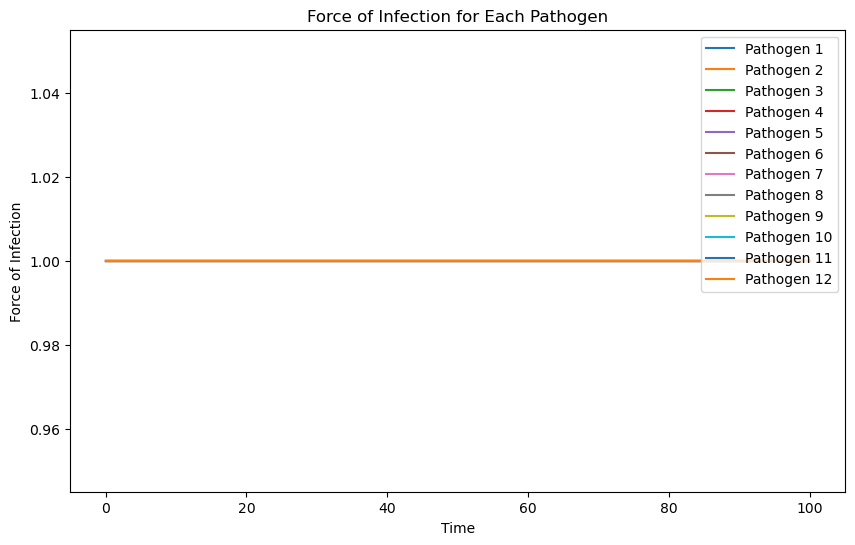

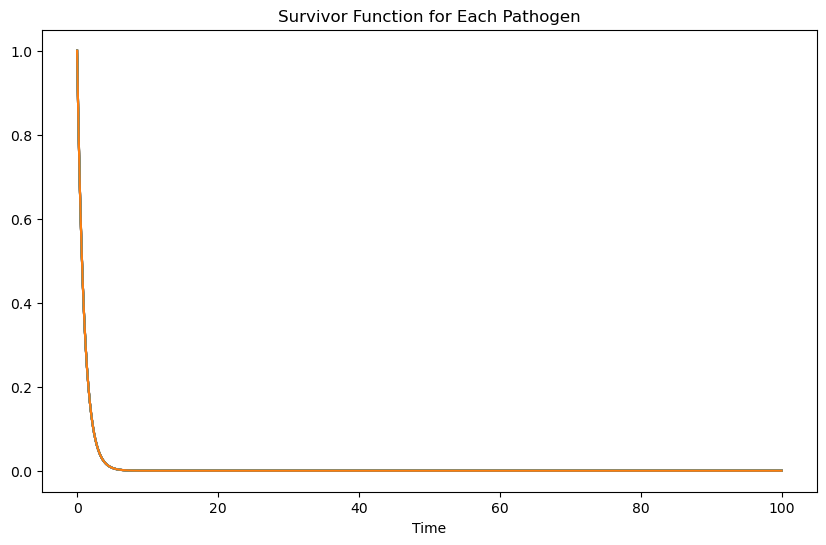

In [3]:
#plot fois
t = np.linspace(0, t_max, 1000)
plt.figure(figsize=(10, 6)) 
for k, foi in enumerate(foi_list):
    plt.plot(t, foi(t), label=pathogen_names[k])
plt.title('Force of Infection for Each Pathogen')
plt.xlabel('Time')
plt.ylabel('Force of Infection')
plt.legend()

#plot survivors
plt.figure(figsize=(10, 6))
for k, survivor in enumerate(survivor_list):
    plt.plot(t, survivor(t), label=pathogen_names[k])
plt.title('Survivor Function for Each Pathogen')
plt.xlabel('Time')

Component 1: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11]
Component 2: [6]


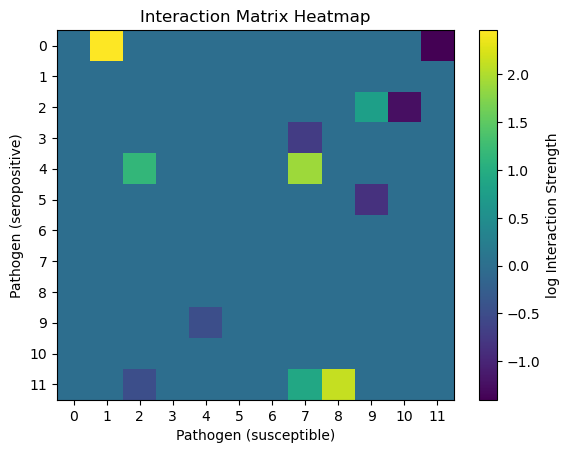

In [4]:
# Interaction matrix

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# spike and slab on each coefficient of the interaction matrix
np.random.seed(42)  # For reproducibility
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
interaction_mat = np.exp(
    np.random.normal(0, 1, size=(n_pathogens, n_pathogens)) * interaction_indicator
)
#plot the interaction matrix as a heatmap
plt.imshow(np.log(interaction_mat), cmap='viridis', aspect='auto')
plt.ylabel('Pathogen (seropositive)')
plt.xlabel('Pathogen (susceptible)')
plt.xticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.yticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.colorbar(label='log Interaction Strength')
plt.title('Interaction Matrix Heatmap')

# Convert interaction_indicator to a sparse matrix
adj_matrix = csr_matrix(interaction_indicator)

# Find weakly connected components (ignoring direction)
n_components, labels = connected_components(csgraph=adj_matrix, directed=True, connection='weak')

# Group node indices by component
components = [np.where(labels == i)[0] for i in range(n_components)]

for i, comp in enumerate(components):
    print(f"Component {i+1}: {comp.tolist()}")

In [5]:
start = time.time()
simulate_infections_df = simulate_infections(n_people, n_pathogens, foi_list, interaction_mat, t_max=t_max, birth_times=birth_times, random_seed=42)
print(f"simulate_infections took {time.time() - start:.3f} seconds")
start = time.time()
survey_df_long = simulation_to_survey_long(
    simulate_infections_df,
    survey_times=100
)
print(f"simulation_to_survey_long took {time.time() - start:.3f} seconds")



simulate_infections took 2.390 seconds
simulation_to_survey_long took 7.353 seconds


In [69]:
#########################
k_infector = 7       # Infecting pathogen to analyze
n_people_subsample = min(100, n_people)  # Subsample size for analysis
#########################


regression_df_for_pathogen_k = simulation_to_regression_df(
    simulate_infections_df,
    k_infector=k_infector,  # Set to None to include all pathogens, or specify a specific pathogen index
    t_max=t_max
)
regression_df_for_pathogen_k_subsampled = regression_df_for_pathogen_k[regression_df_for_pathogen_k["individual"]<=n_people_subsample]

# Bayesian Cox Regression

In [70]:
stan_data = {
    "N": n_people_subsample, # Number of individuals
    "P": n_pathogens - 1, # Number of covariates
    "n_rows": len(regression_df_for_pathogen_k_subsampled), # Number of observation rows
    "T_L": regression_df_for_pathogen_k_subsampled["start_time"].values,
    "T_R": regression_df_for_pathogen_k_subsampled["stop_time"].values,
    "event": regression_df_for_pathogen_k_subsampled["event"].values,
    "person_id": regression_df_for_pathogen_k_subsampled["individual"].values,
    "X": regression_df_for_pathogen_k_subsampled.filter(like='serostatus_').values, # get the data for columns starting with serostatus_,
    "beta_prior_setting": 2, # 0 for no prior, 1 for Laplace prior, 2 for spike and slab prior
    "laplace_scale": 1.0,  # scale for Laplace prior when beta_prior_setting == 1
    "slab_scale": 1.0,  # Scale for the slab in spike and slab prior
    "spike_scale": 0.05,  # Scale for the spike in spike and slab prior
    "pi": 0.1 # Inclusion probability for the spike and slab prior
}

In [ ]:
import os
from pathlib import Path
print(cmdstanpy.cmdstan_path())
print(os.environ["CMDSTAN"])
print(os.environ.get('PATH'))
#cmdstanpy.check_cmdstan_toolchain()


C:\Users\alexy\.cmdstan\cmdstan-2.36.0
C:\Users\alexy\.cmdstan\cmdstan-2.36.0
C:\Users\alexy\.cmdstan\RTools40\mingw64\bin;C:\Users\alexy\.cmdstan\RTools40\usr\bin;C:\Users\alexy\.cmdstan\cmdstan-2.36.0\stan\lib\stan_math\lib\tbb;c:\Users\alexy\miniconda3\envs\multipathogen-sero;C:\Program Files\R\R-4.2.1\bin;C:\Users\alexy\AppData\Local\Programs\Python2\;C:\Users\alexy\AppData\Local\Programs\Python2\Scripts;C:\Program Files\Common Files\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\MATLAB\R2023a\bin;C:\Program Files\PuTTY\;C:\Program Files\Wolfram Research\WolframScript\;C:\Program Files\Git\cmd;C:\WINDOWS\system32\config\systemprofile\AppData\Local\Programs\Python\Python312;C:\WINDOWS\system32\config\systemprofile\AppData\Local\Programs\Python\Python312\Scripts;C:\Program Files\dotnet\;C:\Program Files\Git\bin;C:\Users\alexy\AppData\Local\Packages\PythonSoftwareFou

In [71]:
model = CmdStanModel(stan_file= PROJ_ROOT / "multipathogen_sero" / "infection_histories.stan")

fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=3000,
    iter_warmup=500,
    parallel_chains=4,
    seed=123
)

09:05:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:06:05 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

                     Mean      MCSE    StdDev       MAD        5%       50%  \
lp__            -0.206910  0.088421  3.385550  3.250960 -6.544330  0.268998   
baseline_hazard  0.949979  0.003986  0.176040  0.172349  0.689374  0.933797   
beta_raw[1]     -0.001024  0.000850  0.060225  0.049197 -0.085036 -0.000398   
beta_raw[2]     -0.008950  0.001307  0.061396  0.049035 -0.092360 -0.007364   
beta_raw[3]      0.017104  0.001327  0.069312  0.050129 -0.069169  0.012145   
...                   ...       ...       ...       ...       ...       ...   
log_lik[96

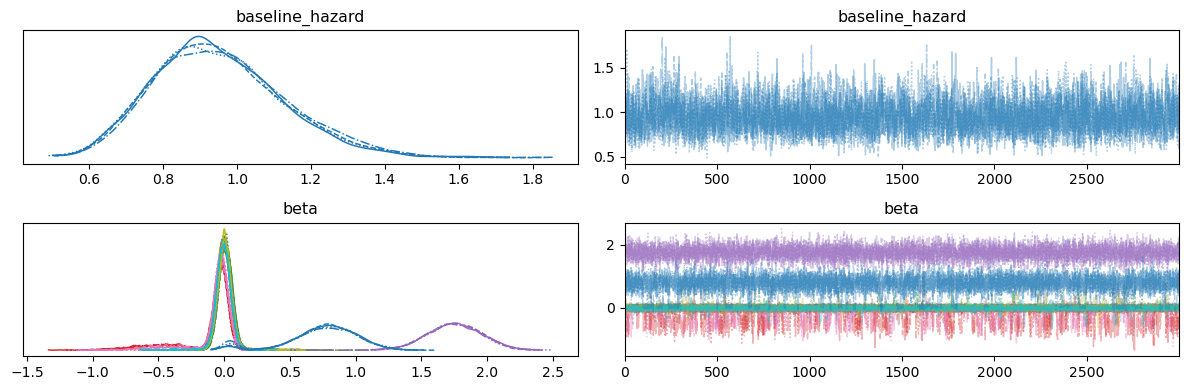

In [72]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazard", "beta"])
plt.tight_layout()
plt.show()

True baseline hazard: 1


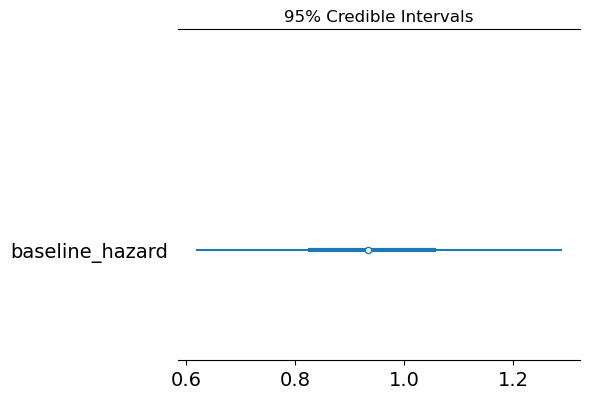

True beta coefficients: [ 0.          0.          0.         -0.71435142  1.89679298  0.
  0.          0.          0.          0.          0.91786195]


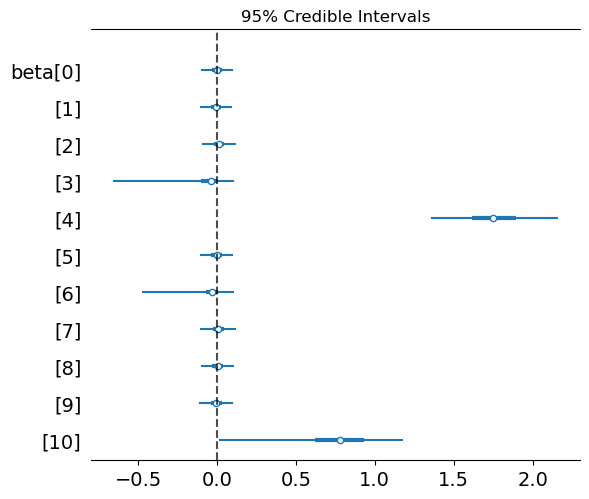

In [73]:
print(f"True baseline hazard: {baseline_hazards[k_infector]}")
az.plot_forest(idata, var_names=["baseline_hazard"], 
               hdi_prob=0.95, combined=True)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {np.log(np.concatenate([interaction_mat[:k_infector, k_infector],interaction_mat[k_infector+1:, k_infector]]))}")

ax = az.plot_forest(idata, var_names=["beta"], 
                    hdi_prob=0.95, combined=True)
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

In [74]:
idata = az.from_cmdstanpy(posterior=fit)
# Now you can calculate WAIC and LOO
waic = az.waic(idata)
loo = az.loo(idata)

print(waic)
print(loo)

c:\Users\alexy\miniconda3\envs\multipathogen-sero\Lib\site-packages\arviz\stats\stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 12000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    -6.10     9.42
p_waic        5.15        -

There has been a warning during the calculation. Please check the results.
Computed from 12000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    -6.15     9.43
p_loo        5.20        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      100  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [5]:
import platform
platform.system() == 'Windows'

True

In [ ]:
cmdstanpy.install_cmdstan()

In [8]:
model = CmdStanModel(stan_file= PROJ_ROOT / "multipathogen_sero" / "piecewise_differentiable.stan")

fit = model.sample(
    data={},
    chains=4,
    iter_sampling=500,
    iter_warmup=500,
    parallel_chains=4,
    seed=123
)

10:54:31 - cmdstanpy - INFO - compiling stan file C:\Users\alexy\sero\multipathogen-sero\multipathogen_sero\piecewise_differentiable.stan to exe file C:\Users\alexy\sero\multipathogen-sero\multipathogen_sero\piecewise_differentiable.exe


ValueError: Failed to compile Stan model 'C:\Users\alexy\sero\multipathogen-sero\multipathogen_sero\piecewise_differentiable.stan'. Console:

--- Translating Stan model to C++ code ---
bin/stanc.exe --filename-in-msg=piecewise_differentiable.stan --o=C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.hpp C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.stan

--- Compiling C++ code ---
x86_64-w64-mingw32-g++.exe -Wno-misleading-indentation  -std=c++17 -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-variable -Wno-sign-compare -Wno-unused-local-typedefs -Wno-int-in-bool-context -Wno-attributes -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials  -D_USE_MATH_DEFINES -D_GLIBCXX11_USE_C99_COMPLEX  -DBOOST_DISABLE_ASSERTS          -c  -x c++ -o C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.o C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.hpp

--- Linking model ---
x86_64-w64-mingw32-g++.exe -Wno-misleading-indentation  -std=c++17 -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-variable -Wno-sign-compare -Wno-unused-local-typedefs -Wno-int-in-bool-context -Wno-attributes -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials  -D_USE_MATH_DEFINES -D_GLIBCXX11_USE_C99_COMPLEX  -DBOOST_DISABLE_ASSERTS               -Wl,-L,"/c/Users/alexy/miniconda3/envs/multipathogen-sero/Library/bin/cmdstan/stan/lib/stan_math/lib/tbb"        C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.o src/cmdstan/main.o  -static-libgcc     -ltbb   stan/lib/stan_math/lib/sundials_6.1.1/lib/libsundials_nvecserial.a stan/lib/stan_math/lib/sundials_6.1.1/lib/libsundials_cvodes.a stan/lib/stan_math/lib/sundials_6.1.1/lib/libsundials_idas.a stan/lib/stan_math/lib/sundials_6.1.1/lib/libsundials_kinsol.a  stan/lib/stan_math/lib/tbb/tbb.dll -o C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.exe
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x5c): undefined reference to `__gthr_win32_mutex_destroy'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x7c): undefined reference to `__gthr_win32_mutex_destroy'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x5e07): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x66e1): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0xe7b1): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x18d09): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x18e12): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1901e): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x191d3): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x195f4): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x19b17): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1a820): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1afb7): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1c493): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1c50e): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1ce3e): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1ce4e): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1d186): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1d196): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1e761): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x1eb79): undefined reference to `__gthr_win32_mutex_destroy'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x22ef2): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x234fb): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x23e09): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x23e63): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x23ee3): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x24d94): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x295e8): undefined reference to `std::istream::seekg(std::fpos<_Mbstatet>)'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x29c74): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2a018): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2a0ec): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2a276): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2a4e0): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2aca1): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2d891): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2e775): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2e996): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2e9f0): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2ea70): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2fa50): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text+0x2fc54): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text.startup+0x8228): undefined reference to `__gthr_win32_mutex_init_function'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text.startup+0x8837): undefined reference to `__gthr_win32_mutex_destroy'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services4util11mcmc_writer10log_timingEdd[_ZN4stan8services4util11mcmc_writer10log_timingEdd]+0xa4): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services4util11mcmc_writer10log_timingEdd[_ZN4stan8services4util11mcmc_writer10log_timingEdd]+0xf9): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services4util11mcmc_writer10log_timingEdd[_ZN4stan8services4util11mcmc_writer10log_timingEdd]+0x185): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4mcmc12diag_e_point12write_metricERNS_9callbacks6writerE[_ZN4stan4mcmc12diag_e_point12write_metricERNS_9callbacks6writerE]+0x62): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN7cmdstan20categorical_argument10print_helpERN4stan9callbacks6writerEib[_ZN7cmdstan20categorical_argument10print_helpERN4stan9callbacks6writerEib]+0x149): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN7cmdstan15argument_parser11print_usageERN4stan9callbacks6writerEPKc[_ZN7cmdstan15argument_parser11print_usageERN4stan9callbacks6writerEPKc]+0x183): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN7cmdstan15argument_parser10parse_argsEiPPKcRN4stan9callbacks6writerES7_[_ZN7cmdstan15argument_parser10parse_argsEiPPKcRN4stan9callbacks6writerES7_]+0xe51): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io13validate_dimsERKNS0_11var_contextERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESB_SB_RKSt6vectorIySaIyEE[_ZN4stan2io13validate_dimsERKNS0_11var_contextERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESB_SB_RKSt6vectorIySaIyEE]+0xc0): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io13validate_dimsERKNS0_11var_contextERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESB_SB_RKSt6vectorIySaIyEE[_ZN4stan2io13validate_dimsERKNS0_11var_contextERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESB_SB_RKSt6vectorIySaIyEE]+0x1e9): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io13validate_dimsERKNS0_11var_contextERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESB_SB_RKSt6vectorIySaIyEE[_ZN4stan2io13validate_dimsERKNS0_11var_contextERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESB_SB_RKSt6vectorIySaIyEE]+0x2c9): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io13validate_dimsERKNS0_11var_contextERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESB_SB_RKSt6vectorIySaIyEE[_ZN4stan2io13validate_dimsERKNS0_11var_contextERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESB_SB_RKSt6vectorIySaIyEE]+0x3b9): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4math16invalid_argumentIiEEvPKcS3_RKT_S3_S3_[_ZN4stan4math16invalid_argumentIiEEvPKcS3_RKT_S3_S3_]+0x22): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math14check_positiveEPKcS2_S2_iENKUlvE_clEv[_ZZN4stan4math14check_positiveEPKcS2_S2_iENKUlvE_clEv]+0x1b): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math16check_size_matchIiiEEvPKcS3_T_S3_T0_ENKUlvE_clEv[_ZZN4stan4math16check_size_matchIiiEEvPKcS3_T_S3_T0_ENKUlvE_clEv]+0x16): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNSt6vectorIySaIyEEC1ERKS1_[_ZNSt6vectorIySaIyEEC1ERKS1_]+0xa1): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNK4stan2io17array_var_context6dims_iERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE[_ZNK4stan2io17array_var_context6dims_iERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE]+0xe9): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNK4stan4json9json_data13validate_dimsERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_S9_RKSt6vectorIySaIyEE[_ZNK4stan4json9json_data13validate_dimsERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_S9_RKSt6vectorIySaIyEE]+0x190): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNK4stan4json9json_data13validate_dimsERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_S9_RKSt6vectorIySaIyEE[_ZNK4stan4json9json_data13validate_dimsERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_S9_RKSt6vectorIySaIyEE]+0x309): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNK4stan4json9json_data13validate_dimsERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_S9_RKSt6vectorIySaIyEE[_ZNK4stan4json9json_data13validate_dimsERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_S9_RKSt6vectorIySaIyEE]+0x51a): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNK4stan4json9json_data13validate_dimsERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_S9_RKSt6vectorIySaIyEE[_ZNK4stan4json9json_data13validate_dimsERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES9_S9_RKSt6vectorIySaIyEE]+0x629): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNSt6vectorIiSaIiEEC1ERKS1_[_ZNSt6vectorIiSaIiEEC1ERKS1_]+0xa1): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNK4stan2io17array_var_context6vals_iERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE[_ZNK4stan2io17array_var_context6vals_iERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE]+0xe1): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNSt6vectorIdSaIdEEC1ERKS1_[_ZNSt6vectorIdSaIdEEC1ERKS1_]+0xa1): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost16cpp_regex_traitsIcE16get_catalog_nameB5cxx11Ev[_ZN5boost16cpp_regex_traitsIcE16get_catalog_nameB5cxx11Ev]+0x5f): undefined reference to `__gthr_win32_mutex_unlock'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost16cpp_regex_traitsIcE16get_catalog_nameB5cxx11Ev[_ZN5boost16cpp_regex_traitsIcE16get_catalog_nameB5cxx11Ev]+0x78): undefined reference to `__gthr_win32_mutex_lock'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost16cpp_regex_traitsIcE16get_catalog_nameB5cxx11Ev[_ZN5boost16cpp_regex_traitsIcE16get_catalog_nameB5cxx11Ev]+0xaf): undefined reference to `__gthr_win32_mutex_init_function'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost16cpp_regex_traitsIcE16get_catalog_nameB5cxx11Ev[_ZN5boost16cpp_regex_traitsIcE16get_catalog_nameB5cxx11Ev]+0x130): undefined reference to `__gthr_win32_mutex_unlock'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler7booleanEb[_ZN4stan4json17json_data_handler7booleanEb]+0x31): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler4nullEv[_ZN4stan4json17json_data_handler4nullEv]+0x31): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io15stan_csv_reader13read_metadataERSiRNS0_17stan_csv_metadataE[_ZN4stan2io15stan_csv_reader13read_metadataERSiRNS0_17stan_csv_metadataE]+0x25): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io15stan_csv_reader13read_metadataERSiRNS0_17stan_csv_metadataE[_ZN4stan2io15stan_csv_reader13read_metadataERSiRNS0_17stan_csv_metadataE]+0x24b): undefined reference to `std::istream::seekg(std::fpos<_Mbstatet>)'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io15stan_csv_reader15read_adaptationERSiRNS0_19stan_csv_adaptationE[_ZN4stan2io15stan_csv_reader15read_adaptationERSiRNS0_19stan_csv_adaptationE]+0x5d): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io15stan_csv_reader15read_adaptationERSiRNS0_19stan_csv_adaptationE[_ZN4stan2io15stan_csv_reader15read_adaptationERSiRNS0_19stan_csv_adaptationE]+0x1fc): undefined reference to `std::istream::seekg(std::fpos<_Mbstatet>)'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io15stan_csv_reader15read_adaptationERSiRNS0_19stan_csv_adaptationE[_ZN4stan2io15stan_csv_reader15read_adaptationERSiRNS0_19stan_csv_adaptationE]+0x5b9): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math16check_size_matchIixEEvPKcS3_T_S3_T0_ENKUlvE_clEv[_ZZN4stan4math16check_size_matchIixEEvPKcS3_T_S3_T0_ENKUlvE_clEv]+0x16): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math16check_size_matchIiyEEvPKcS3_T_S3_T0_ENKUlvE_clEv[_ZZN4stan4math16check_size_matchIiyEEvPKcS3_T_S3_T0_ENKUlvE_clEv]+0x16): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4math22check_lower_triangularIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEELPv0EEEvPKcS7_RKT_[_ZN4stan4math22check_lower_triangularIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEELPv0EEEvPKcS7_RKT_]+0x92): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4math16invalid_argumentIxEEvPKcS3_RKT_S3_S3_[_ZN4stan4math16invalid_argumentIxEEvPKcS3_RKT_S3_S3_]+0x22): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math16check_size_matchIxiEEvPKcS3_T_S3_T0_ENKUlvE_clEv[_ZZN4stan4math16check_size_matchIxiEEvPKcS3_T_S3_T0_ENKUlvE_clEv]+0x16): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math16check_size_matchIxxEEvPKcS3_T_S3_T0_ENKUlvE_clEv[_ZZN4stan4math16check_size_matchIxxEEvPKcS3_T_S3_T0_ENKUlvE_clEv]+0x16): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math16check_size_matchIxxEEvPKcS3_S3_T_S3_S3_T0_ENKUlvE_clEv[_ZZN4stan4math16check_size_matchIxxEEvPKcS3_S3_T_S3_S3_T0_ENKUlvE_clEv]+0x19): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math16check_size_matchIxxEEvPKcS3_S3_T_S3_S3_T0_ENKUlvE_clEv[_ZZN4stan4math16check_size_matchIxxEEvPKcS3_S3_T_S3_S3_T0_ENKUlvE_clEv]+0x58): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan8services19standalone_generateINS_5model10model_baseENS_9callbacks20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteIS9_EEEEEiRKT_iRKSt6vectorIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEESaISJ_EEjRNS4_9interruptERNS4_6loggerERSG_IT0_SaISS_EEENKUlRKN3tbb13blocked_rangeIyEEE_clES10_[_ZZN4stan8services19standalone_generateINS_5model10model_baseENS_9callbacks20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteIS9_EEEEEiRKT_iRKSt6vectorIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEESaISJ_EEjRNS4_9interruptERNS4_6loggerERSG_IT0_SaISS_EEENKUlRKN3tbb13blocked_rangeIyEEE_clES10_]+0xa6): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math15check_symmetricIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEELPv0EEEvPKcS7_RKT_ENKUlvE_clEv[_ZZN4stan4math15check_symmetricIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEELPv0EEEvPKcS7_RKT_ENKUlvE_clEv]+0x1f): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZZN4stan4math15check_symmetricIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEELPv0EEEvPKcS7_RKT_ENKUlvE_clEv[_ZZN4stan4math15check_symmetricIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEELPv0EEEvPKcS7_RKT_ENKUlvE_clEv]+0xd0): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN7cmdstan13list_argument10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS7_EERN4stan9callbacks6writerESE_Rb[_ZN7cmdstan13list_argument10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS7_EERN4stan9callbacks6writerESE_Rb]+0x2e8): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN7cmdstan18singleton_argumentINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEE10parse_argsERSt6vectorIS6_SaIS6_EERN4stan9callbacks6writerESF_Rb[_ZN7cmdstan18singleton_argumentINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEE10parse_argsERSt6vectorIS6_SaIS6_EERN4stan9callbacks6writerESF_Rb]+0x248): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN7cmdstan18singleton_argumentIiE10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERN4stan9callbacks6writerESF_Rb[_ZN7cmdstan18singleton_argumentIiE10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERN4stan9callbacks6writerESF_Rb]+0x1c6): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN7cmdstan18singleton_argumentIdE10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERN4stan9callbacks6writerESF_Rb[_ZN7cmdstan18singleton_argumentIdE10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERN4stan9callbacks6writerESF_Rb]+0x181): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN7cmdstan18singleton_argumentIjE10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERN4stan9callbacks6writerESF_Rb[_ZN7cmdstan18singleton_argumentIjE10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERN4stan9callbacks6writerESF_Rb]+0x1c6): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN7cmdstan18singleton_argumentIxE10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERN4stan9callbacks6writerESF_Rb[_ZN7cmdstan18singleton_argumentIxE10parse_argsERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERN4stan9callbacks6writerESF_Rb]+0x1c8): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4math18throw_domain_errorIA1_cEEvPKcS4_RKT_S4_S4_[_ZN4stan4math18throw_domain_errorIA1_cEEvPKcS4_RKT_S4_S4_]+0x22): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4math18throw_domain_errorIyEEvPKcS3_RKT_S3_S3_[_ZN4stan4math18throw_domain_errorIyEEvPKcS3_RKT_S3_S3_]+0x22): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan2io17array_var_contextC1ERKSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERKS2_IdSaIdEERKS2_IS2_IySaIyEESaISI_EE[_ZN4stan2io17array_var_contextC1ERKSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EERKS2_IdSaIdEERKS2_IS2_IySaIyEESaISI_EE]+0x6a9): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4math8internal30elementwise_throw_domain_errorIJPKcS4_S4_S4_yS4_dS4_S4_S4_EEEvDpKT_[_ZN4stan4math8internal30elementwise_throw_domain_errorIJPKcS4_S4_S4_yS4_dS4_S4_S4_EEEvDpKT_]+0x3d): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4math8internal30elementwise_throw_domain_errorIJPKcS4_S4_S4_yS4_yS4_dS4_S4_S4_EEEvDpKT_[_ZN4stan4math8internal30elementwise_throw_domain_errorIJPKcS4_S4_S4_yS4_yS4_dS4_S4_S4_EEEvDpKT_]+0x3d): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNK4stan11variational15normal_fullrank4sqrtEv[_ZNK4stan11variational15normal_fullrank4sqrtEv]+0x451): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNK4stan11variational15normal_fullrank6squareEv[_ZNK4stan11variational15normal_fullrank6squareEv]+0x57c): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services4psis12psis_weightsIN5Eigen5ArrayIdLin1ELi1ELi0ELin1ELi1EEENS_9callbacks6loggerEEES5_RKT_xRT0_[_ZN4stan8services4psis12psis_weightsIN5Eigen5ArrayIdLin1ELi1ELi0ELin1ELi1EEENS_9callbacks6loggerEEES5_RKT_xRT0_]+0x3d4): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4math18throw_domain_errorIA26_cEEvPKcS4_RKT_S4_S4_[_ZN4stan4math18throw_domain_errorIA26_cEEvPKcS4_RKT_S4_S4_]+0x22): undefined reference to `std::__cxx11::basic_ostringstream<char, std::char_traits<char>, std::allocator<char> >::basic_ostringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services4util9gq_writer15write_gq_valuesINS_5model10model_baseEN5boost6random13mixmax_engineILi17ELj36ELx0EEEEEvRKT_RT0_RSt6vectorIdSaIdEE[_ZN4stan8services4util9gq_writer15write_gq_valuesINS_5model10model_baseEN5boost6random13mixmax_engineILi17ELj36ELx0EEEEEvRKT_RT0_RSt6vectorIdSaIdEE]+0x4b): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services19standalone_generateINS_5model10model_baseEEEiRKT_RKN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEEjRNS_9callbacks9interruptERNSC_6loggerERNSC_6writerE[_ZN4stan8services19standalone_generateINS_5model10model_baseEEEiRKT_RKN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEEjRNS_9callbacks9interruptERNSC_6loggerERNSC_6writerE]+0xbe): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services19standalone_generateINS_5model10model_baseENS_9callbacks20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteIS9_EEEEEiRKT_iRKSt6vectorIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEESaISJ_EEjRNS4_9interruptERNS4_6loggerERSG_IT0_SaISS_EE[_ZN4stan8services19standalone_generateINS_5model10model_baseENS_9callbacks20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteIS9_EEEEEiRKT_iRKSt6vectorIN5Eigen6MatrixIdLin1ELin1ELi0ELin1ELin1EEESaISJ_EEjRNS4_9interruptERNS4_6loggerERSG_IT0_SaISS_EE]+0x690): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler14set_outer_dimsENS0_10array_dimsE[_ZN4stan4json17json_data_handler14set_outer_dimsENS0_10array_dimsE]+0x25a): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler11start_arrayEv[_ZN4stan4json17json_data_handler11start_arrayEv]+0x8e): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler19save_key_value_pairEv[_ZN4stan4json17json_data_handler19save_key_value_pairEv]+0xb61): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler19save_key_value_pairEv[_ZN4stan4json17json_data_handler19save_key_value_pairEv]+0xedc): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler19save_key_value_pairEv[_ZN4stan4json17json_data_handler19save_key_value_pairEv]+0xfec): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler19save_key_value_pairEv[_ZN4stan4json17json_data_handler19save_key_value_pairEv]+0x1629): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler9end_arrayEv[_ZN4stan4json17json_data_handler9end_arrayEv]+0x242): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler6stringERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE[_ZN4stan4json17json_data_handler6stringERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE]+0x12c): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler10end_objectEv[_ZN4stan4json17json_data_handler10end_objectEv]+0x3ee): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler10end_objectEv[_ZN4stan4json17json_data_handler10end_objectEv]+0x59a): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan5model14test_gradientsILb1ELb1ENS0_10model_baseEEEiRKT1_RSt6vectorIdSaIdEERS6_IiSaIiEEddRNS_9callbacks9interruptERNSD_6loggerERNSD_6writerE[_ZN4stan5model14test_gradientsILb1ELb1ENS0_10model_baseEEEiRKT1_RSt6vectorIdSaIdEERS6_IiSaIiEEddRNS_9callbacks9interruptERNSD_6loggerERNSD_6writerE]+0x7a): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan5model14test_gradientsILb1ELb1ENS0_10model_baseEEEiRKT1_RSt6vectorIdSaIdEERS6_IiSaIiEEddRNS_9callbacks9interruptERNSD_6loggerERNSD_6writerE[_ZN4stan5model14test_gradientsILb1ELb1ENS0_10model_baseEEEiRKT1_RSt6vectorIdSaIdEERS6_IiSaIiEEddRNS_9callbacks9interruptERNSD_6loggerERNSD_6writerE]+0x1f3): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan5model14test_gradientsILb1ELb1ENS0_10model_baseEEEiRKT1_RSt6vectorIdSaIdEERS6_IiSaIiEEddRNS_9callbacks9interruptERNSD_6loggerERNSD_6writerE[_ZN4stan5model14test_gradientsILb1ELb1ENS0_10model_baseEEEiRKT1_RSt6vectorIdSaIdEERS6_IiSaIiEEddRNS_9callbacks9interruptERNSD_6loggerERNSD_6writerE]+0x2e9): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan5model14test_gradientsILb1ELb1ENS0_10model_baseEEEiRKT1_RSt6vectorIdSaIdEERS6_IiSaIiEEddRNS_9callbacks9interruptERNSD_6loggerERNSD_6writerE[_ZN4stan5model14test_gradientsILb1ELb1ENS0_10model_baseEEEiRKT1_RSt6vectorIdSaIdEERS6_IiSaIiEEddRNS_9callbacks9interruptERNSD_6loggerERNSD_6writerE]+0x5fd): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services4util10initializeILb1ENS_5model10model_baseENS_2io11var_contextEN5boost6random13mixmax_engineILi17ELj36ELx0EEEEESt6vectorIdSaIdEERT0_RKT1_RT2_dbRNS_9callbacks6loggerERNSL_6writerE[_ZN4stan8services4util10initializeILb1ENS_5model10model_baseENS_2io11var_contextEN5boost6random13mixmax_engineILi17ELj36ELx0EEEEESt6vectorIdSaIdEERT0_RKT1_RT2_dbRNS_9callbacks6loggerERNSL_6writerE]+0x1b6): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services4util10initializeILb1ENS_5model10model_baseENS_2io11var_contextEN5boost6random13mixmax_engineILi17ELj36ELx0EEEEESt6vectorIdSaIdEERT0_RKT1_RT2_dbRNS_9callbacks6loggerERNSL_6writerE[_ZN4stan8services4util10initializeILb1ENS_5model10model_baseENS_2io11var_contextEN5boost6random13mixmax_engineILi17ELj36ELx0EEEEESt6vectorIdSaIdEERT0_RKT1_RT2_dbRNS_9callbacks6loggerERNSL_6writerE]+0x40a): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNK4stan2io18random_var_context7names_rERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EE[_ZNK4stan2io18random_var_context7names_rERSt6vectorINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEESaIS8_EE]+0x219): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZNSt10_HashtableINSt6thread2idESt4pairIKS1_St10unique_ptrIN4stan4math22AutodiffStackSingletonINS6_9vari_baseENS6_15chainable_allocEEESt14default_deleteISA_EEESaISE_ENSt8__detail10_Select1stESt8equal_toIS1_ESt4hashIS1_ENSG_18_Mod_range_hashingENSG_20_Default_ranged_hashENSG_20_Prime_rehash_policyENSG_17_Hashtable_traitsILb0ELb0ELb1EEEE9_M_rehashEyRKy[_ZNSt10_HashtableINSt6thread2idESt4pairIKS1_St10unique_ptrIN4stan4math22AutodiffStackSingletonINS6_9vari_baseENS6_15chainable_allocEEESt14default_deleteISA_EEESaISE_ENSt8__detail10_Select1stESt8equal_toIS1_ESt4hashIS1_ENSG_18_Mod_range_hashingENSG_20_Default_ranged_hashENSG_20_Prime_rehash_policyENSG_17_Hashtable_traitsILb0ELb0ELb1EEEE9_M_rehashEyRKy]+0x137): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services4util11mcmc_writer19write_sample_paramsINS_5model10model_baseEN5boost6random13mixmax_engineILi17ELj36ELx0EEEEEvRT0_RNS_4mcmc6sampleERNSC_9base_mcmcERT_[_ZN4stan8services4util11mcmc_writer19write_sample_paramsINS_5model10model_baseEN5boost6random13mixmax_engineILi17ELj36ELx0EEEEEvRT0_RNS_4mcmc6sampleERNSC_9base_mcmcERT_]+0xa0): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample11fixed_paramINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_[_ZN4stan8services6sample11fixed_paramINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_]+0x366): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample11fixed_paramINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_[_ZN4stan8services6sample11fixed_paramINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_]+0x3c0): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample11fixed_paramINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_[_ZN4stan8services6sample11fixed_paramINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_]+0x440): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZSt16__do_uninit_copyIPKSt6vectorIdSaIdEEPS2_ET0_T_S7_S6_[_ZSt16__do_uninit_copyIPKSt6vectorIdSaIdEEPS2_ET0_T_S7_S6_]+0xde): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0x111): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0x474): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0x6d4): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0xbdc): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0xd0b): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize5lbfgsINS_5model10model_baseELb1EEEiRT_RKNS_2io11var_contextEjjdiddddddibiRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0xe59): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample16hmc_nuts_dense_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE[_ZN4stan8services6sample16hmc_nuts_dense_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE]+0x6f6): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample16hmc_nuts_dense_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE[_ZN4stan8services6sample16hmc_nuts_dense_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE]+0x706): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample16hmc_nuts_dense_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE[_ZN4stan8services6sample16hmc_nuts_dense_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE]+0x716): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample15hmc_nuts_diag_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE[_ZN4stan8services6sample15hmc_nuts_diag_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE]+0x6f6): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample15hmc_nuts_diag_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE[_ZN4stan8services6sample15hmc_nuts_diag_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE]+0x706): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample15hmc_nuts_diag_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE[_ZN4stan8services6sample15hmc_nuts_diag_eINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_EEiRT_yRKSt6vectorIT0_SaISM_EEjjdiiibiddiRNS9_9interruptERNS9_6loggerERSL_IT1_SaISV_EERSL_IT2_SaISZ_EERSL_IT3_SaIS13_EE]+0x716): more undefined references to `std::__throw_bad_array_new_length()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan5model8gradientINS0_10model_baseEEEvRKT_RKN5Eigen6MatrixIdLin1ELi1ELi0ELin1ELi1EEERdRS8_RNS_9callbacks6loggerE[_ZN4stan5model8gradientINS0_10model_baseEEEvRKT_RKN5Eigen6MatrixIdLin1ELi1ELi0ELin1ELi1EEERdRS8_RNS_9callbacks6loggerE]+0x2c): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample21hmc_nuts_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibiddiddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_RNSB_17structured_writerE[_ZN4stan8services6sample21hmc_nuts_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibiddiddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_RNSB_17structured_writerE]+0xd63): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample21hmc_nuts_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibiddiddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_RNSB_17structured_writerE[_ZN4stan8services6sample21hmc_nuts_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibiddiddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_RNSB_17structured_writerE]+0xf67): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample21hmc_nuts_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibiddiddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_RNSB_17structured_writerE[_ZN4stan8services6sample21hmc_nuts_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibiddiddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_RNSB_17structured_writerE]+0xfb9): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample21hmc_nuts_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibiddiddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_RNSB_17structured_writerE[_ZN4stan8services6sample21hmc_nuts_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibiddiddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_RNSB_17structured_writerE]+0x1031): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample23hmc_static_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibidddddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_[_ZN4stan8services6sample23hmc_static_unit_e_adaptINS_5model10model_baseEEEiRT_RKNS_2io11var_contextEjjdiiibidddddddRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_SH_]+0xd70): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample21hmc_nuts_diag_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE[_ZN4stan8services6sample21hmc_nuts_diag_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE]+0x876): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample21hmc_nuts_diag_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE[_ZN4stan8services6sample21hmc_nuts_diag_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE]+0x886): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample21hmc_nuts_diag_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE[_ZN4stan8services6sample21hmc_nuts_diag_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE]+0x896): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost13re_detail_50012perl_matcherIN9__gnu_cxx17__normal_iteratorIPKcNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEEESaINS_9sub_matchISC_EEENS_12regex_traitsIcNS_16cpp_regex_traitsIcEEEEE11match_matchEv[_ZN5boost13re_detail_50012perl_matcherIN9__gnu_cxx17__normal_iteratorIPKcNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEEESaINS_9sub_matchISC_EEENS_12regex_traitsIcNS_16cpp_regex_traitsIcEEEEE11match_matchEv]+0x43b): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost13re_detail_50012perl_matcherIN9__gnu_cxx17__normal_iteratorIPKcNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEEESaINS_9sub_matchISC_EEENS_12regex_traitsIcNS_16cpp_regex_traitsIcEEEEE11match_matchEv[_ZN5boost13re_detail_50012perl_matcherIN9__gnu_cxx17__normal_iteratorIPKcNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEEESaINS_9sub_matchISC_EEENS_12regex_traitsIcNS_16cpp_regex_traitsIcEEEEE11match_matchEv]+0x440): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost13match_resultsIN9__gnu_cxx17__normal_iteratorIPKcNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEEESaINS_9sub_matchISB_EEEEC1ERKSF_[_ZN5boost13match_resultsIN9__gnu_cxx17__normal_iteratorIPKcNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEEESaINS_9sub_matchISB_EEEEC1ERKSF_]+0x130): more undefined references to `std::__throw_bad_array_new_length()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost12object_cacheINS_13re_detail_50021cpp_regex_traits_baseIcEENS1_31cpp_regex_traits_implementationIcEEE3getERKS3_y[_ZN5boost12object_cacheINS_13re_detail_50021cpp_regex_traits_baseIcEENS1_31cpp_regex_traits_implementationIcEEE3getERKS3_y]+0x45): undefined reference to `__gthr_win32_mutex_unlock'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost12object_cacheINS_13re_detail_50021cpp_regex_traits_baseIcEENS1_31cpp_regex_traits_implementationIcEEE3getERKS3_y[_ZN5boost12object_cacheINS_13re_detail_50021cpp_regex_traits_baseIcEENS1_31cpp_regex_traits_implementationIcEEE3getERKS3_y]+0x60): undefined reference to `__gthr_win32_mutex_lock'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost12object_cacheINS_13re_detail_50021cpp_regex_traits_baseIcEENS1_31cpp_regex_traits_implementationIcEEE3getERKS3_y[_ZN5boost12object_cacheINS_13re_detail_50021cpp_regex_traits_baseIcEENS1_31cpp_regex_traits_implementationIcEEE3getERKS3_y]+0x8b): undefined reference to `__gthr_win32_mutex_init_function'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN5boost12object_cacheINS_13re_detail_50021cpp_regex_traits_baseIcEENS1_31cpp_regex_traits_implementationIcEEE3getERKS3_y[_ZN5boost12object_cacheINS_13re_detail_50021cpp_regex_traits_baseIcEENS1_31cpp_regex_traits_implementationIcEEE3getERKS3_y]+0xb8): undefined reference to `__gthr_win32_mutex_unlock'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan4json17json_data_handler3keyERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE[_ZN4stan4json17json_data_handler3keyERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE]+0x2a3): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0x120): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0x18a): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0x6cd): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0x814): undefined reference to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_[_ZN4stan8services8optimize6newtonINS_5model10model_baseELb0EEEiRT_RKNS_2io11var_contextEjjdibRNS_9callbacks9interruptERNSB_6loggerERNSB_6writerESH_]+0x998): more undefined references to `std::__cxx11::basic_stringstream<char, std::char_traits<char>, std::allocator<char> >::basic_stringstream()' follow
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample22hmc_nuts_dense_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE[_ZN4stan8services6sample22hmc_nuts_dense_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE]+0x876): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample22hmc_nuts_dense_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE[_ZN4stan8services6sample22hmc_nuts_dense_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE]+0x886): undefined reference to `std::__throw_bad_array_new_length()'
C:/Users/alexy/.cmdstan/RTools40/mingw64/bin/../lib/gcc/x86_64-w64-mingw32/8.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: src/cmdstan/main.o:main.cpp:(.text$_ZN4stan8services6sample22hmc_nuts_dense_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE[_ZN4stan8services6sample22hmc_nuts_dense_e_adaptINS_5model10model_baseESt10shared_ptrINS_2io11var_contextEENS_9callbacks6writerENS9_20unique_stream_writerISt14basic_ofstreamIcSt11char_traitsIcEESt14default_deleteISF_EEESI_NS9_11json_writerISF_SH_EEEEiRT_yRKSt6vectorIT0_SaISO_EEjjdiiibiddiddddjjjRNS9_9interruptERNS9_6loggerERSN_IT1_SaISX_EERSN_IT2_SaIS11_EERSN_IT3_SaIS15_EERSN_IT4_SaIS19_EE]+0x896): undefined reference to `std::__throw_bad_array_new_length()'
collect2.exe: error: ld returned 1 exit status
make: *** [make/program:82: C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.exe] Error 1
rm C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.o C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.hpp

Command ['make', 'STANCFLAGS+=--filename-in-msg=piecewise_differentiable.stan', 'C:/Users/alexy/sero/multipathogen-sero/multipathogen_sero/piecewise_differentiable.exe']
	error during processing No such file or directory


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

          Mean      MCSE    StdDev       MAD       5%       50%       95%  \
lp__ -0.907013  0.036623  0.881258  0.656502 -2.67572 -0.639896 -0.051197   
beta -0.018483  0.052742  1.264660  0.948867 -2.11725  0.001861  2.011070   

      ESS_bulk  ESS_tail    R_hat  
lp__   644.682   711.346  1.00169  
beta   624.795   656.210  1.00482  
Any R-hat > 1.01? False
Any ESS < 400? False


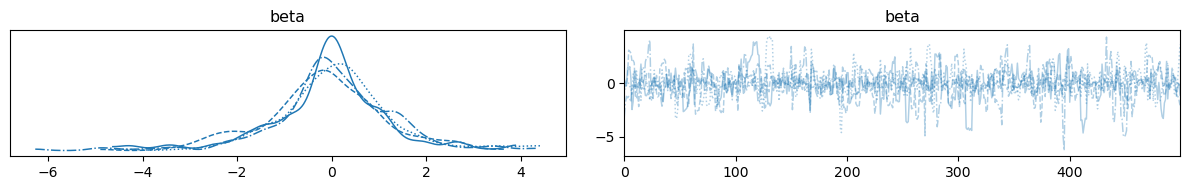

In [10]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["beta"])
plt.tight_layout()
plt.show()